# Prostate MRI Dataset

In [1]:
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt

dir_path = os.path.join('data', 'data')

In [2]:
def trim_2D(array, value):
    
    epsilon = 1e-2

    # trim x
    for i in range(array.shape[0]):
        if abs(np.sum(array[i,:]) / array[i,:].shape[0] - value) > epsilon:
            break
    for j in reversed(range(array.shape[0])):
        if abs(np.sum(array[j,:]) / array[j,:].shape[0] - value) > epsilon:
            break
    array = array[i:j+1,:]
    
    # trim y
    for i in range(array.shape[1]):
        if abs(np.sum(array[:,i]) / array[:,i].shape[0] - value) > epsilon:
            break
    for j in reversed(range(array.shape[1])):
        if abs(np.sum(array[:,j]) / array[:,j].shape[0] - value) > epsilon:
            break
    array = array[:,i:j+1]
    
    return(array)

In [3]:
data = []
for i, file in enumerate(os.listdir(dir_path)):
    
    mat_file = scipy.io.loadmat(os.path.join(dir_path, file))
    
    pid = mat_file['casesTableArr'][0][0][0][0][0][0][0]
    
    patient_dict = {}
    
    patient_dict['id'] = pid
    patient_dict['T2'] = mat_file['T2']
    patient_dict['ADC'] = mat_file['ADC']
    patient_dict['CDI'] = mat_file['CDI']
    patient_dict['HBV'] = mat_file['HBV']
    patient_dict['PIRADS_score'] = mat_file['casesTableArr'][0][0][1][0][0]
    patient_dict['curGleason_score'] = mat_file['casesTableArr'][0][0][2][0][0]
    patient_dict['maxGleason_score'] = mat_file['casesTableArr'][0][0][3][0][0]
    patient_dict['PIRADS_map'] = mat_file['casesTableArr'][0][0][4]
    patient_dict['curGleason_map'] = mat_file['casesTableArr'][0][0][5]
    patient_dict['maxGleason_map'] = mat_file['casesTableArr'][0][0][6]
    patient_dict['mask'] = mat_file['PMask']
    patient_dict['zone_map'] = mat_file['casesTableArr'][0][0][7]
        
    data.append(patient_dict)

In [4]:
fold_dict = {}
with open('5folds.txt', 'r') as f:
    for line in f:
        pid, fold_no = line.split()
        fold_dict[str(pid)] = int(fold_no)

In [5]:
examples = {}
labels = []
max_adc = 3949

for modality in ['ADC', 'HBV']: # TODO: add T2-weighted images (if we get the labels)
    
    label_map = 'maxGleason_map'
    zone_map = 'zone_map'
        
    examples[modality] = []
    
    for _ in range(5):
        examples[modality].append([])
        labels.append([])

    for patient in data:
        
        pid = patient['id']
        if pid in ['P00000015', 'P00000249', 'P00000429']: # remove bad data
            continue

        fold_id = fold_dict[pid] - 1

        patient_examples = []
        patient_labels = []

        if patient[zone_map].shape[-1] != patient[modality].shape[-1]: # check if segmentation map has same num slices as mri
            continue

        for slice_index in range(patient[modality].shape[-1]):

            for zone_index in range(10):
                zone_number = zone_index + 1

                if zone_number in patient[zone_map][:,:,slice_index]: # check zone map to see if the slice contains the zone

                    binary_mask = patient[zone_map][:,:,slice_index] == zone_number  # create a binary mask
                    
                    if modality == 'ADC':
                        adc_mask = np.invert(binary_mask) * max_adc # mask using max adc value
                        example = patient[modality][:,:,slice_index] * binary_mask  # apply the mask to the slice
                        example = example + adc_mask
                        trimmed_example = trim_2D(example, max_adc)
                    else:
                        example = patient[modality][:,:,slice_index] * binary_mask  # apply the mask to the slice
                        trimmed_example = trim_2D(example, 0)  # trim the slice to the dimensions of the prostate zone
                    
                    patient_examples.append(trimmed_example)
                    patient_labels.append(1 if patient[label_map][slice_index][zone_index] >0 else 0)

        examples[modality][fold_id].extend(patient_examples)
        labels[fold_id].extend(patient_labels)

In [6]:
#aucs = []
for i in range(5): # CV Loop
    
    x_train = []
    y_train = []
    
    x_test = examples['HBV'][i]
    y_test = labels[i]
    
    for j in range(5):
        if i != j:
            x_train.extend(examples['HBV'][j])
            y_train.extend(labels[j])
                
    # TODO: feature extraction / features selection / classification here
    
    # auc = auc_calculation(y_pred, y_test)
    
# mean_auc = sum(aucs) / float(len(aucs))
# print(mean_auc)

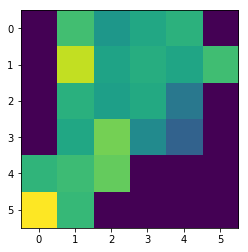

In [7]:
plt.imshow(x_train[9])

In [8]:
x_train[9]

array([[  0.        ,  72.92454449,  55.56084737,  62.79511204,
         67.34659737,   0.        ],
       [  0.        ,  95.14516444,  60.8231382 ,  65.42253413,
         61.7183382 ,  72.77728833],
       [  0.        ,  66.621497  ,  59.24214257,  63.54369517,
         41.78152263,   0.        ],
       [  0.        ,  62.60982999,  82.75911341,  50.2072637 ,
         33.09171456,   0.        ],
       [ 68.58323863,  71.80440163,  80.0520225 ,   0.        ,
          0.        ,   0.        ],
       [104.8489149 ,  70.21425883,   0.        ,   0.        ,
          0.        ,   0.        ]])

In [9]:
#aucs = []
for i in range(5): # CV Loop
    
    x_train = []
    y_train = []
    
    x_test = examples['ADC'][i]
    y_test = labels[i]
    
    for j in range(5):
        if i != j:
            x_train.extend(examples['ADC'][j])
            y_train.extend(labels[j])
                
    # TODO: feature extraction / features selection / classification here
    
    # auc = auc_calculation(y_pred, y_test)
    
# mean_auc = sum(aucs) / float(len(aucs))
# print(mean_auc)

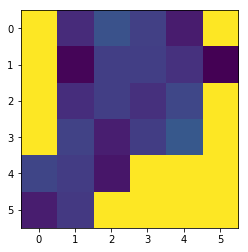

In [10]:
plt.imshow(x_train[9])

In [11]:
x_train[9]

array([[3949.        , 1781.1179542 , 2096.59463096, 1951.25038423,
        1667.23986406, 3949.        ],
       [3949.        , 1512.6479901 , 1940.79508515, 1938.73027446,
        1828.2337713 , 1478.41179129],
       [3949.        , 1806.47306319, 1933.19941712, 1819.89751845,
        2004.10510127, 3949.        ],
       [3949.        , 1962.28228623, 1683.64493816, 1923.00544784,
        2158.36545182, 3949.        ],
       [1999.39636022, 1921.38492333, 1631.12132018, 3949.        ,
        3949.        , 3949.        ],
       [1675.25412909, 1888.94071647, 3949.        , 3949.        ,
        3949.        , 3949.        ]])